# Part 1: Data Exploration and Model Building (55 Marks)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import re
import pickle
from tqdm import tqdm
import multiprocessing
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.io as pio
import seaborn as sns
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from ignite.metrics import Rouge
from transformers import AutoTokenizer

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning:

`TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.



## I. Importing Libraries and Data

In [2]:
def load_split(split_name):
    """Function to load a specific split of the dataset."""
    return load_dataset("abisee/cnn_dailymail", "3.0.0", split=split_name)

In [3]:
# Define the splits you want to download
splits = ['train', 'test', 'validation']
# Create a pool of workers
with multiprocessing.Pool(processes=len(splits)) as pool:
    # Map the load_split function to the splits
    results = pool.map(load_split, splits)
# Unpack results
train_ds, test_ds, val_ds = results
# Now you can use train_ds, test_ds, val_ds as needed
print(f"Train dataset: {train_ds}")
print(f"Test dataset: {test_ds}")
print(f"Validation dataset: {val_ds}")

Train dataset: Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})
Test dataset: Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})
Validation dataset: Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 13368
})


In [4]:
SUBSET_SIZE = 0.1
train_indices = torch.randperm(len(train_ds))[
    : int(SUBSET_SIZE * len(train_ds))
].tolist()
train_ds = torch.utils.data.Subset(train_ds, train_indices)
val_indices = torch.randperm(len(val_ds))[: int(SUBSET_SIZE * len(val_ds))].tolist()
val_ds = torch.utils.data.Subset(val_ds, val_indices)

## II. Data Preprocessing

In [5]:
replacement_patterns = [
            (r"won\'t", "will not"),
            (r"can\'t", "cannot"),
            (r"i\'m", "i am"),
            (r"ain\'t", "is not"),
            (r"(\w+)\'ll", "\g<1> will"),
            (r"(\w+)n\'t", "\g<1> not"),
            (r"(\w+)\'ve", "\g<1> have"),
            (r"(\w+)\'s", "\g<1> is"),
            (r"(\w+)\'re", "\g<1> are"),
            (r"(\w+)\'d", "\g<1> would"),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]

In [6]:
class EDA:
    def __init__(self, save_path: str = None):
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2", clean_up_tokenization_spaces=True)
        self.tokenizer.add_special_tokens({"pad_token": "<pad>",
                                           "bos_token": "<sos>",
                                           "eos_token": "<eos>",
                                           "unk_token": "<unk>",})
        self.vocab_size = len(self.tokenizer.get_vocab())
        self.word_counts = {}
        self.sentence_lengths = {}
        for data_type in ["article", "highlights"]:
            if save_path is not None:
                with open(os.path.join(save_path, f"{data_type}_word_counts.pkl"), "rb") as f:
                    self.word_counts[data_type] = pickle.load(f)
                with open(os.path.join(save_path, f"{data_type}_sentence_lengths.pkl"), "rb") as f:
                    self.sentence_lengths[data_type] = pickle.load(f)
            else:
                self.word_counts[data_type] = Counter()
                self.sentence_lengths[data_type] = Counter()

    def clean_text(self, sentence: str):
        # Define cleaning patterns
        sentence = sentence.lower()
        for pattern, repl in patterns:
            sentence = re.sub(pattern, repl, sentence)
        # Remove non-alphanumeric characters
        sentence = re.sub(r"[^\w\s]", "", sentence)
        return sentence
        
    def plot_word_freq(self, words, counts, col_name, ds_name, file_name='word_frequency_plot.png'):
        """Plot the top most frequent words in a specified column of a DataFrame."""
        data = [go.Bar(x=words, y=counts, marker=dict(colorscale='Jet', color=counts))]
        layout = go.Layout(
            title=f'Top {len(words)} Word Frequencies in "{col_name}" Column in "{ds_name}" Dataset',
            xaxis_title=f'Words of "{col_name}" Column',
            yaxis_title='Frequencies'
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename=file_name)
        pio.write_image(fig, file_name)

    def visualize_sentence_lengths(self, sentence_lengths, col_name, ds_name):
        """Visualize the distribution of sentence lengths."""
        # Convert sentence lengths to DataFrame
        df = pd.DataFrame(list(sentence_lengths.items()), columns=['Sentence Length', 'Frequency'])
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Sentence Length', y='Frequency', data=df)
        plt.title(f'Sentence Lengths in "{col_name}" Column in "{ds_name}" Dataset')
        plt.xlabel('Sentence Lengths')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()
        
    def plot_statistics(self, title: str, word_counts: dict = None, sentence_lengths: dict = None, num_most_frequent: int = 10):
        most_frequent_words = Counter(word_counts).most_common(num_most_frequent)
        fig, axs = plt.subplots(1, 2, figsize=(24, 8))
        fig.suptitle(title)
        # Plot most frequent tokens
        axs[0].bar([word[0] for word in most_frequent_words],
                   [word[1] for word in most_frequent_words])
        axs[0].set_title("Most Frequent Tokens")
        axs[0].set_xlabel("Tokens")
        axs[0].set_ylabel("Frequency")
        # Prepare data for the box plot
        df = pd.DataFrame(list(sentence_lengths.items()), columns=['Sentence Length', 'Frequency'])
        # Use the frequency counts to represent the box plot in the second subplot
        sns.boxplot(x='Sentence Length', data=df, ax=axs[1], color='lightblue')
        axs[1].set_title('Sentence Lengths Distribution')
        axs[1].set_xlabel('Sentence Lengths')
        axs[1].set_ylabel('Frequency')
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
        plt.show()

    def build_vocab(self, dataset, data_type: str = "article"):
        for i in tqdm(range(len(dataset)), total=len(dataset)):
            text = dataset[i][data_type]
            text = self.clean_text(text)
            words = self.tokenizer.tokenize(text, max_length=3000, truncation=True)
            self.word_counts[data_type].update(words)
            self.sentence_lengths[data_type].update([len(words)])
        # Save the word counts and sentence lengths
        with open(f"{data_type}_word_counts.pkl", "wb") as f:
            pickle.dump(self.word_counts[data_type], f)
        with open(f"{data_type}_sentence_lengths.pkl", "wb") as f:
            pickle.dump(self.sentence_lengths[data_type], f)

## III. Tokenization and Vocabulary Generation

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

100%|██████████| 28711/28711 [03:47<00:00, 126.35it/s]


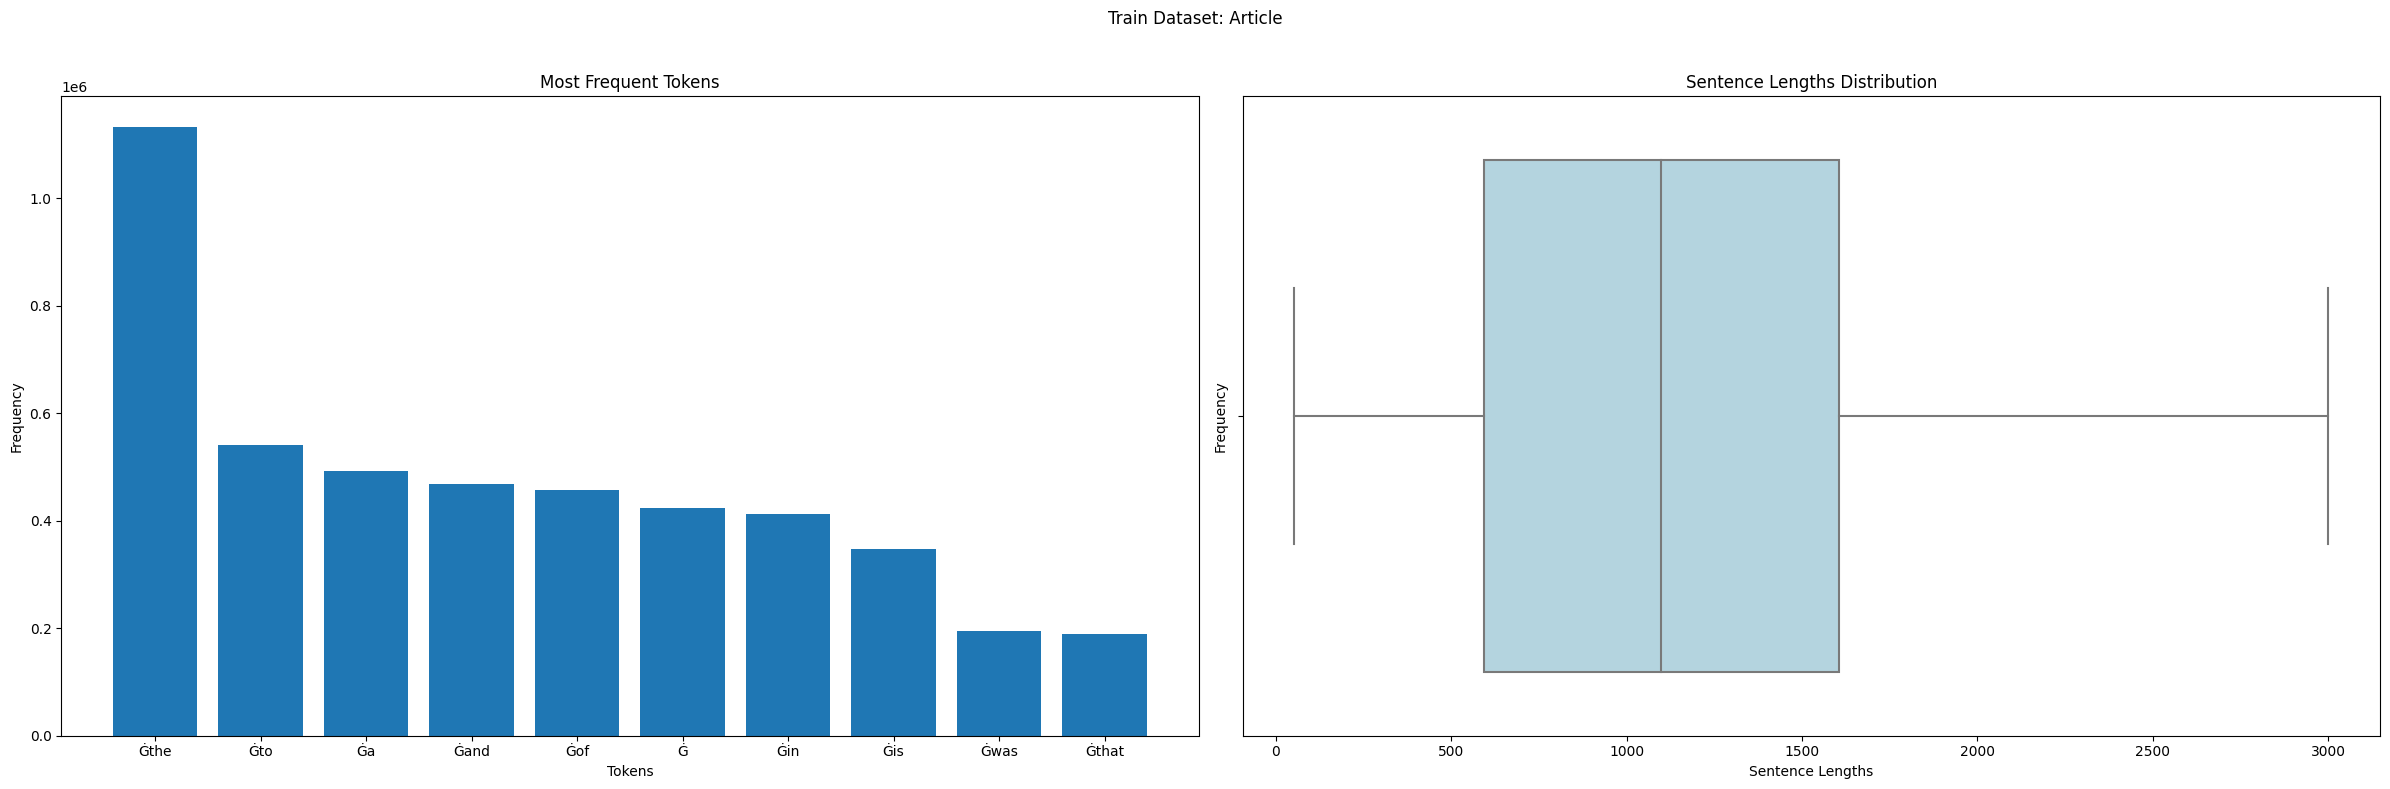

100%|██████████| 28711/28711 [00:24<00:00, 1182.26it/s]


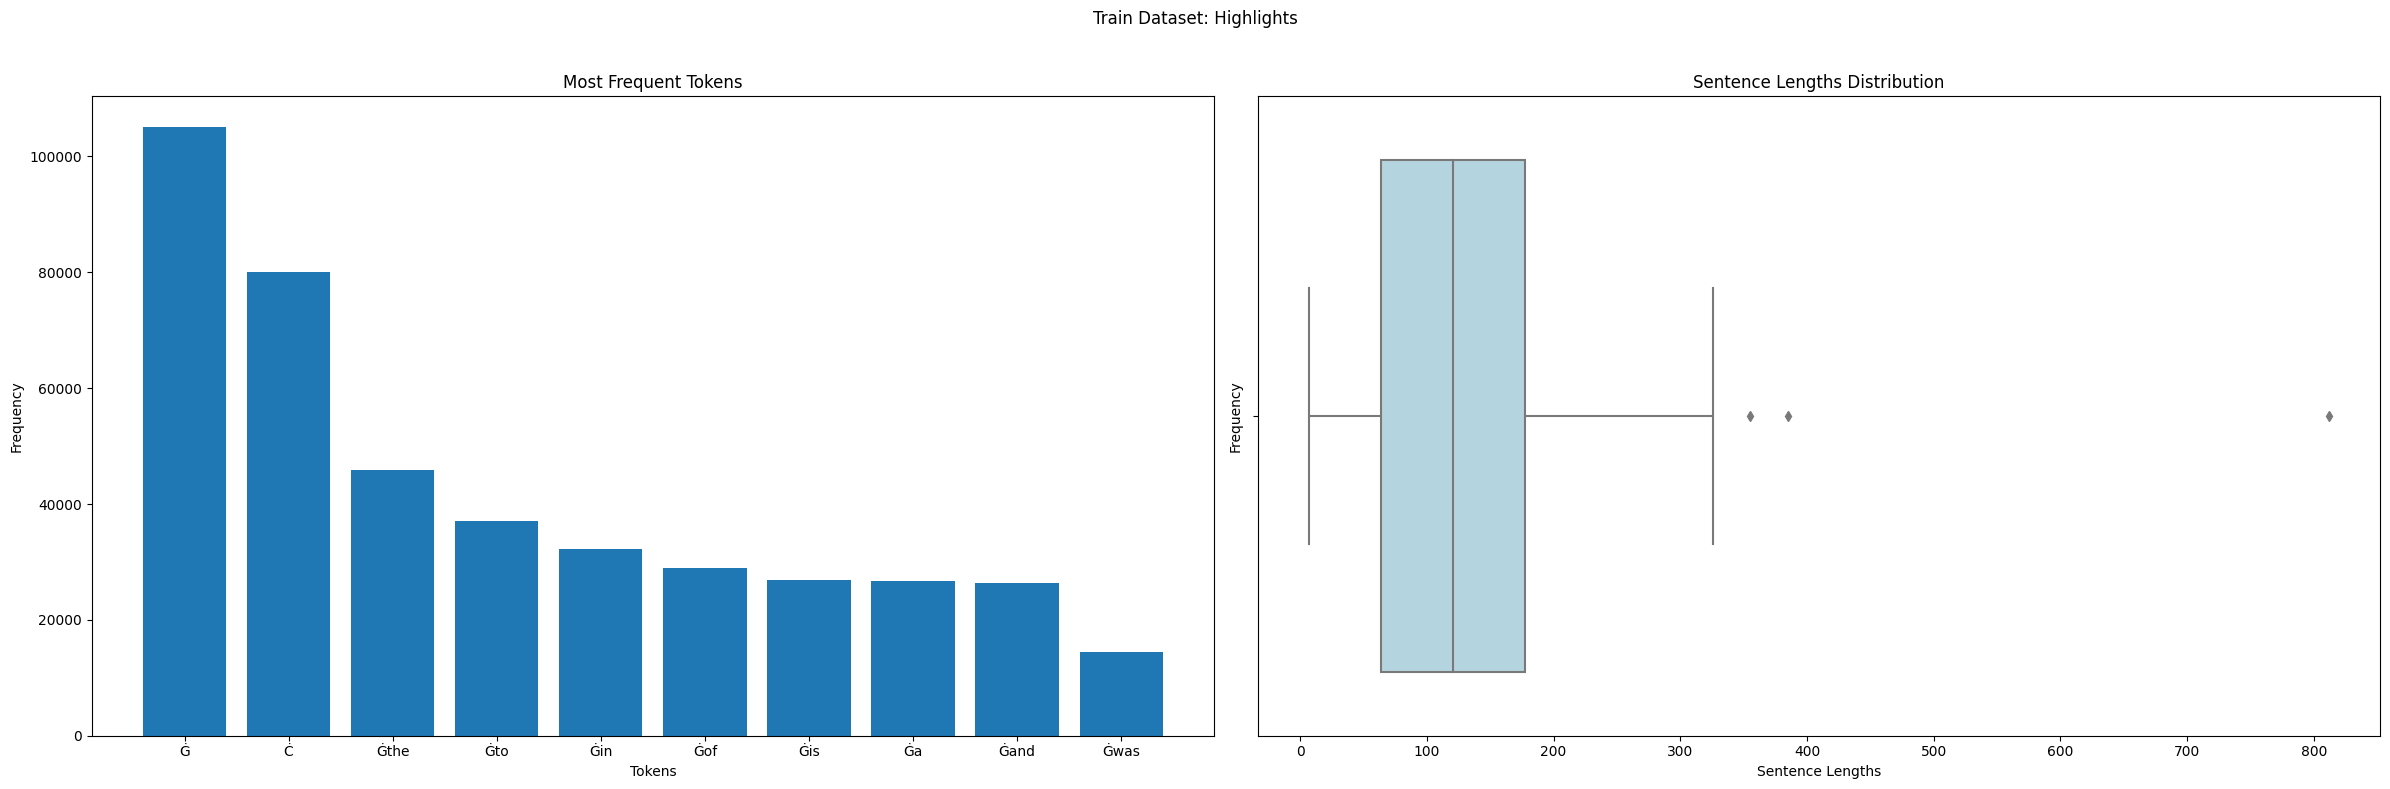

100%|██████████| 1336/1336 [00:10<00:00, 132.23it/s]


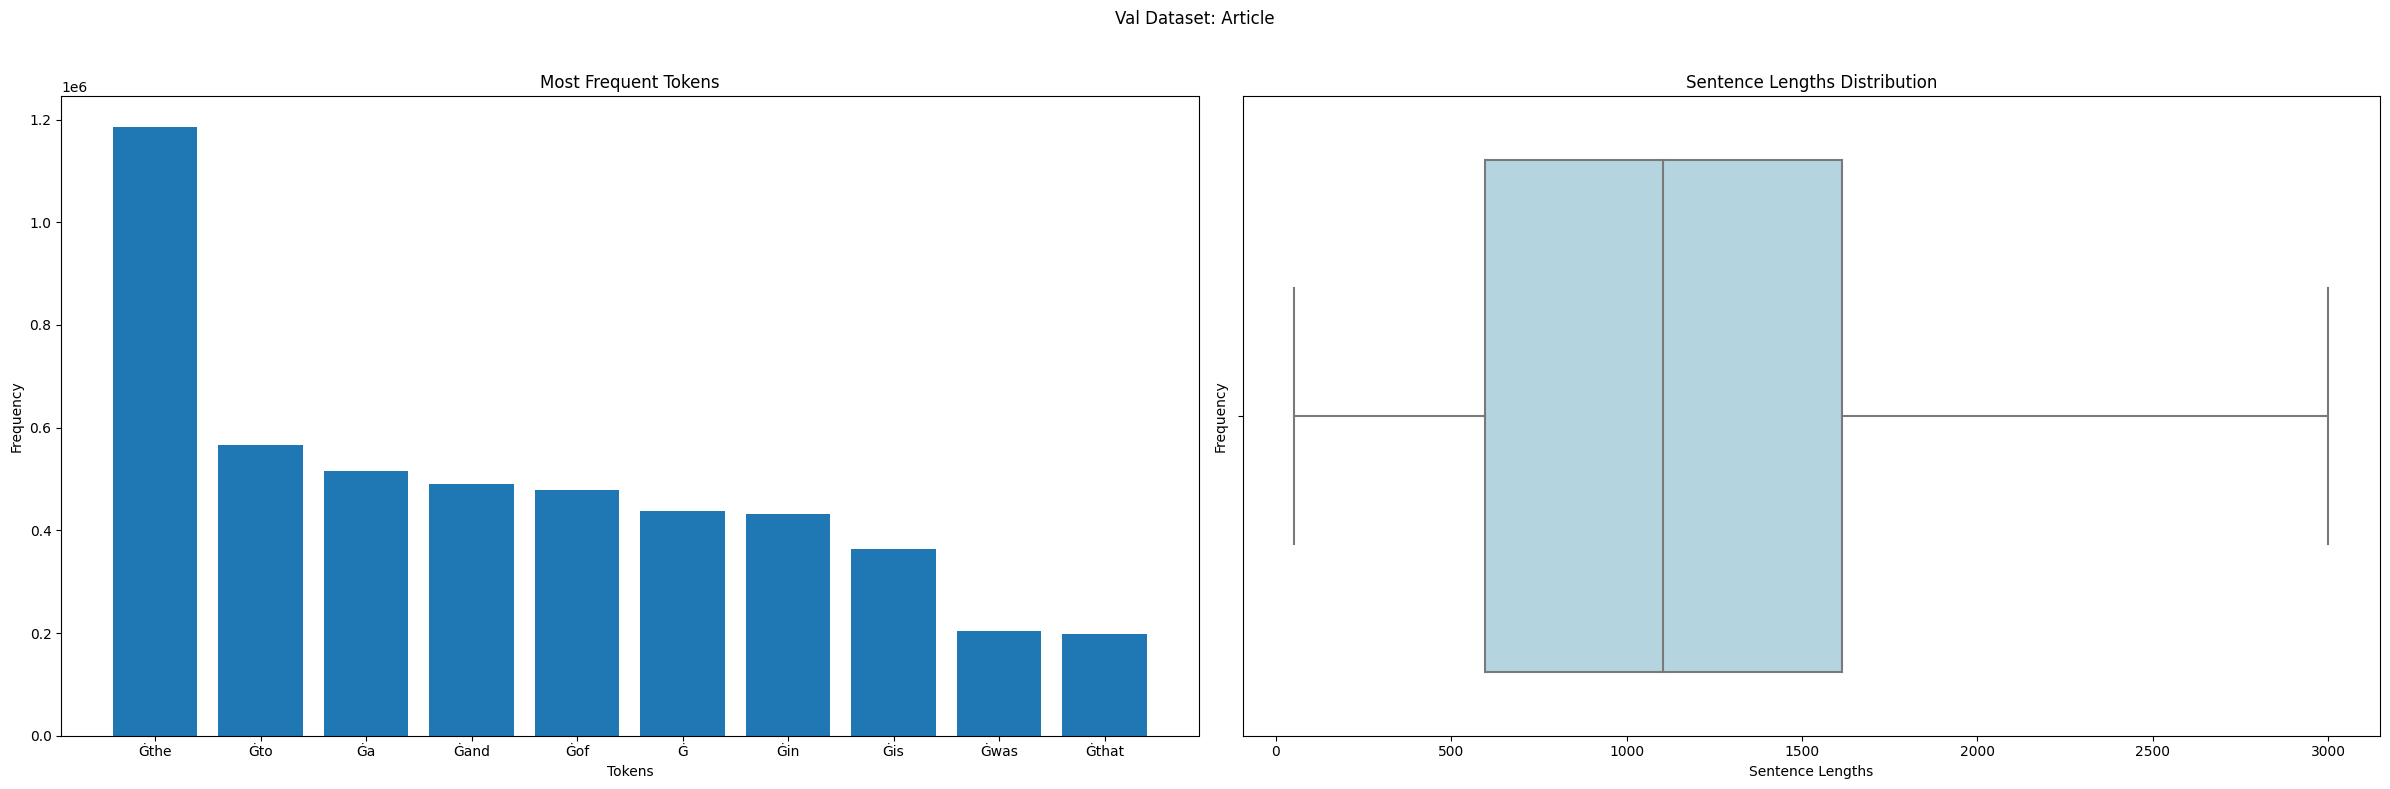

100%|██████████| 1336/1336 [00:01<00:00, 1059.13it/s]


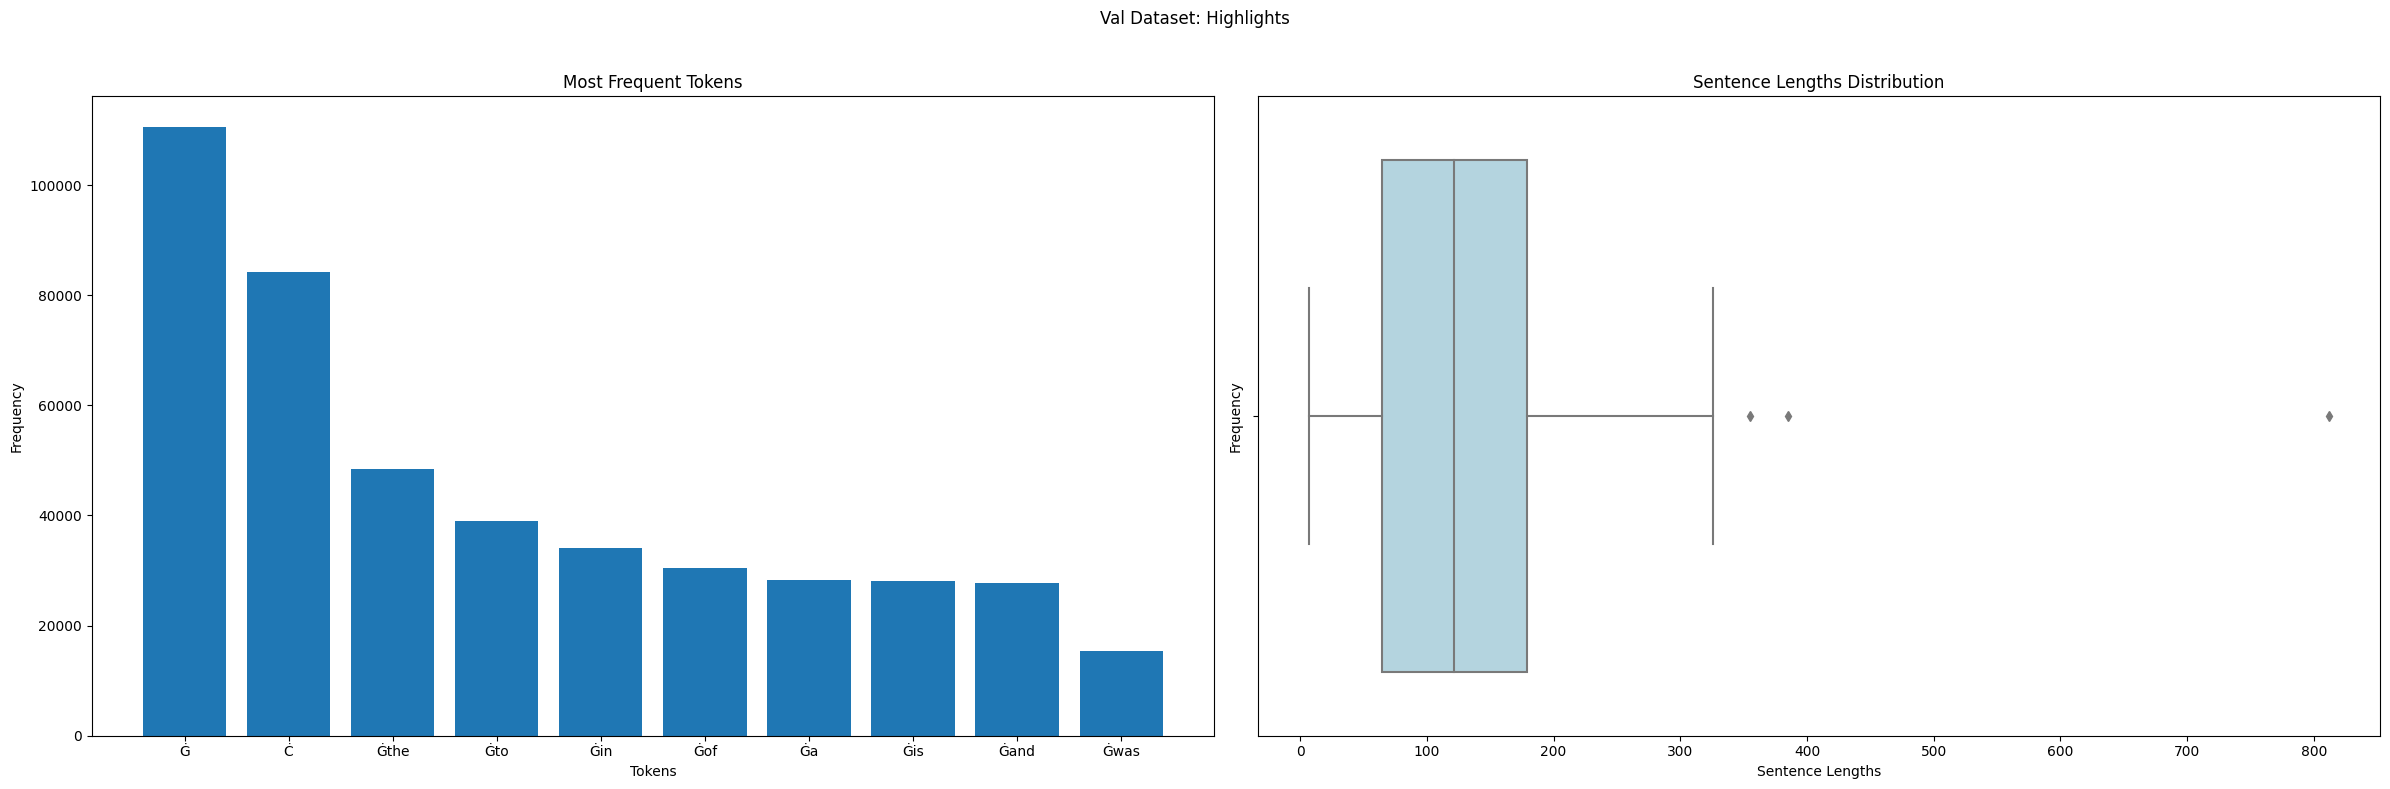

In [7]:
v = EDA()
types = ["article", "highlights"]
datasets = {"train": train_ds, "val": val_ds}

for dataset_name, dataset in datasets.items():
    for data_type in types:
        v.build_vocab(dataset, data_type)
        v.plot_statistics(
            f"{dataset_name.capitalize()} Dataset: {data_type.capitalize()}",
            v.word_counts[data_type],
            v.sentence_lengths[data_type],
        )

## IV. Model Architechture


In [8]:
MAX_LENGTH = 200
PAD_IDX = v.tokenizer.pad_token_id
SOS_IDX = v.tokenizer.bos_token_id
EOS_IDX = v.tokenizer.eos_token_id
UNK_IDX = v.tokenizer.unk_token_id
device = ("cuda" if torch.cuda.is_available() else 
          "mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
# Define the Seq2Seq model with integrated encoder, decoder, and attention mechanism
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super(Seq2Seq, self).__init__()
        self.hidden_size = hidden_size
        # Encoder
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD_IDX)
        self.gru_encoder = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        # Attention mechanism
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        # Decoder
        self.embedding_decoder = nn.Embedding(output_size, hidden_size, padding_idx=PAD_IDX)
        self.gru_decoder = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor, target_tensor=None):
        # Encoder forward pass
        encoder_outputs, encoder_hidden = self.encode(input_tensor)
        # Decoder forward pass
        decoder_outputs, attentions = self.decode(encoder_outputs, encoder_hidden, target_tensor)
        return decoder_outputs, attentions

    def encode(self, input_tensor):
        embedded = self.dropout(self.embedding(input_tensor))
        encoder_outputs, encoder_hidden = self.gru_encoder(embedded)
        return encoder_outputs, encoder_hidden

    def attention(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

    def decode(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        if target_tensor is not None:  # Teacher Forcing
            for i in range(target_tensor.size(1)):
                decoder_output, decoder_hidden, attn_weights = self.forward_step(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_outputs.append(decoder_output)
                attentions.append(attn_weights)
                decoder_input = target_tensor[:, i].unsqueeze(1)
        else:
            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attn_weights = self.forward_step(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_outputs.append(decoder_output)
                attentions.append(attn_weights)
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
                if decoder_input.item() == EOS_IDX:
                    decoder_outputs.pop()
                    break
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, attentions

    def forward_step(self, decoder_input, decoder_hidden, encoder_outputs):
        embedded = self.dropout(self.embedding_decoder(decoder_input))
        # Attention context
        query = decoder_hidden.permute(1, 0, 2)  # Reshape to batch_first
        context, attn_weights = self.attention(query, encoder_outputs)
        # Combine embedding and attention context, then pass to GRU
        input_gru = torch.cat((embedded, context), dim=2)
        output, decoder_hidden = self.gru_decoder(input_gru, decoder_hidden)
        output = self.out(output)
        return output, decoder_hidden, attn_weights

In [10]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if abs(validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [11]:
def model_summary(model, input_size):
    def count_params(module):
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    def get_layer_output_shape(layer, input_shape):
        with torch.no_grad():
            dummy_input = torch.ones(*input_shape, dtype=torch.long, device=device)
            if isinstance(layer, nn.Embedding):
                return (input_shape[0], input_shape[1], layer.embedding_dim)
            elif isinstance(layer, nn.GRU):
                output, _ = layer(dummy_input)
                return output.size()
            elif isinstance(layer, nn.Linear):
                return (input_shape[0], layer.out_features)
            return input_shape

    print(f"{'Layer (type)':<40} {'Output Shape':<30} {'Param #':>10}")
    print("=" * 80)
    
    total_params = 0
    trainable_params = 0
    non_trainable_params = 0

    # Input
    print(f"{'Input Layer':<40} {str((input_size[0], input_size[1])):<30} 0")
    
    # Embedding layer (Encoder)
    layer = model.embedding
    output_shape = get_layer_output_shape(layer, input_size)
    params = count_params(layer)
    print(f"{'Embedding (Encoder)':<40} {str(output_shape):<30} {params:>10}")
    total_params += params
    trainable_params += params

    # GRU Encoder
    layer = model.gru_encoder
    output_shape = get_layer_output_shape(layer, output_shape)
    params = count_params(layer)
    print(f"{'GRU (Encoder)':<40} {str(output_shape):<30} {params:>10}")
    total_params += params
    trainable_params += params

    # Attention Mechanism
    for attention_layer_name in ['Wa', 'Ua', 'Va']:
        layer = getattr(model, attention_layer_name)
        params = count_params(layer)
        output_shape = (input_size[0], input_size[1], model.hidden_size)
        print(f"{f'{attention_layer_name} (Attention)':<40} {str(output_shape):<30} {params:>10}")
        total_params += params
        trainable_params += params

    # Embedding layer (Decoder)
    layer = model.embedding_decoder
    output_shape = get_layer_output_shape(layer, (input_size[0], 1))
    params = count_params(layer)
    print(f"{'Embedding (Decoder)':<40} {str(output_shape):<30} {params:>10}")
    total_params += params
    trainable_params += params

    # GRU Decoder
    layer = model.gru_decoder
    output_shape = get_layer_output_shape(layer, (input_size[0], 1, 2 * model.hidden_size))
    params = count_params(layer)
    print(f"{'GRU (Decoder)':<40} {str(output_shape):<30} {params:>10}")
    total_params += params
    trainable_params += params

    # Linear layer
    layer = model.out
    output_shape = get_layer_output_shape(layer, (input_size[0], model.hidden_size))
    params = count_params(layer)
    print(f"{'Linear (Output)':<40} {str(output_shape):<30} {params:>10}")
    total_params += params
    trainable_params += params

    print("=" * 80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")

In [12]:
# Utility Function to fuse optimizer step into backward pass
def attach_optimizer_hooks(model):
    # Instead of having just *one* optimizer, we will have a ``dict`` of optimizers
    # for every parameter so we could reference them in our hook.
    optimizer_dict = {
        p: torch.optim.Adam([p], lr=1e-3, betas=(0.9, 0.98), eps=1e-9, foreach=False)
        for p in model.parameters()
    }
    # Define our hook, which will call the optimizer ``step()`` and ``zero_grad()``
    def optimizer_hook(parameter) -> None:
        optimizer_dict[parameter].step()
        optimizer_dict[parameter].zero_grad()
    # Register the hook onto every parameter
    for p in model.parameters():
        p.register_post_accumulate_grad_hook(optimizer_hook)
        # Initialize the parameters
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [13]:
def transform_input_token(sentence: str, vocab: EDA = v):
    sentence = sentence.lower()
    for pattern, repl in patterns:
        sentence = re.sub(pattern, repl, sentence)
    sentence = re.sub(r"[^\w\s]", "", sentence)
    sentence = sentence + " <eos>"
    words = vocab.tokenizer.encode(sentence, max_length=3000, truncation=True)
    return torch.tensor(words)

def transform_output_token(ids, vocab: EDA = v):
    """Converts token ids back to text."""
    if ids.dim() not in {1, 2}:
        raise RuntimeError(f"Expected ids to have 1 or 2 dimensions, got {ids.dim()} dimensions")
    return (vocab.tokenizer.batch_decode if ids.dim() == 2 else vocab.tokenizer.decode)(ids, skip_special_tokens=True)

def collate_fn(batch: list):
    """Pads inputs with pad_idx to have batches of equal length."""
    src_batch, tgt_batch = zip(*[(transform_input_token(v["article"]), transform_input_token(v["highlights"])) for v in batch])
    return pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True), pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)

In [14]:
def plotLoss(train_loss, val_loss):
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Training and Validation Loss")
    axs[0].plot(train_loss, label="Train Loss", color="blue")
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Batch Index")
    axs[0].set_ylabel("Loss")
    axs[1].plot(val_loss, label="Validation Loss", color="red")
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Batch Index")
    axs[1].set_ylabel("Loss")
    plt.show()

In [15]:
def train_epoch(dataloader, model, criterion):
    loss_history = []
    model.train()  # Set model to training mode
    tepoch = tqdm(dataloader, total=len(dataloader))
    for data in tepoch:
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)
        # Forward pass through the Seq2Seq model
        decoder_outputs, attentions = model(input_tensor, target_tensor)
        # Compute loss
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        # Backward pass (computing gradients)
        loss.backward()
        # Gradient clipping (check if gradient exists first)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        # Track the loss for history
        loss_history.append(loss.item())
        tepoch.set_postfix({"loss": loss.item()})
    return loss_history

In [16]:
def eval(dataloader, model, criterion):
    model.eval()  # Set the model to evaluation mode
    loss_history = []
    tepoch = tqdm(dataloader, total=len(dataloader))
    rouge = Rouge(variants=["L", 2])  # ROUGE metrics
    with torch.no_grad():
        for data in tepoch:
            input_tensor, target_tensor = data
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)
            # Forward pass through the combined Seq2Seq model
            output, _ = model(input_tensor, target_tensor)
            # Compute the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # Reshape to (batch_size * seq_len, vocab_size)
                target_tensor.view(-1)  # Reshape to (batch_size * seq_len)
            )
            # Get predictions from the model output
            pred = transform_output_token(output.argmax(-1))  # Get the index with the highest probability
            pred = [sent.split() for sent in pred]
            target = transform_output_token(target_tensor)
            target = [sent.split() for sent in target]
            # Update the ROUGE scores
            rouge.update((pred, [target]))
            loss_history.append(loss.item())
            tepoch.set_postfix({"loss": loss.item()})
    # Compute final ROUGE score across the entire dataset
    rouge_score = rouge.compute()
    return loss_history, rouge_score

In [17]:
def train(train_dataloader, val_dataloader, model, n_epochs, plot_every=1):
    attach_optimizer_hooks(model)  # Assuming this function sets up optimizers for the model
    criterion = nn.NLLLoss(ignore_index=PAD_IDX)
    early_stopper = EarlyStopping(tolerance=3, min_delta=0.01)
    for epoch in range(1, n_epochs + 1):
        model.train()  # Set model to training mode
        total_train_loss = 0  # Accumulate train loss
        # Perform a training step for the current batch and return batch loss
        train_loss = train_epoch(train_dataloader, model, criterion)
        val_loss, rouge_scores = eval(val_dataloader, model, criterion)
        print(f"Epoch: {epoch}, Train Loss: {train_loss[-1]:.4f}, Val ROUGE-L: {rouge_scores['Rouge-L-F']:.4f}, Val ROUGE-2: {rouge_scores['Rouge-2-F']:.4f}")
        # Check early stopping based on validation loss
        early_stopper(torch.sum(torch.tensor(train_loss)).item(), torch.sum(torch.tensor(val_loss)).item())
        if epoch % plot_every == 0:
            plotLoss(train_loss, val_loss) # Plot training vs validation loss
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch}...")
            break

## V. Training Model (Encoder-Decoder Architecture)

In [18]:
HIDDEN_SIZE = 128
BATCH_SIZE = 8
model = Seq2Seq(v.vocab_size, HIDDEN_SIZE, v.vocab_size).to(device)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

100%|██████████| 167/167 [00:27<00:00,  6.15it/s, loss=6.09]


Epoch: 1, Train Loss: 6.0055, Val ROUGE-L: 0.1241, Val ROUGE-2: 0.0102


<Figure size 640x480 with 0 Axes>

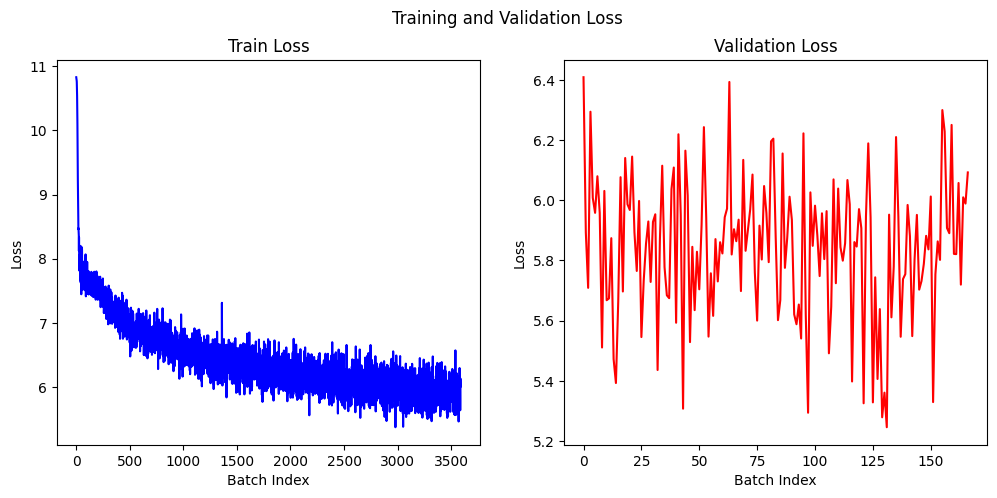

100%|██████████| 167/167 [00:27<00:00,  6.12it/s, loss=5.83]


Epoch: 2, Train Loss: 5.5867, Val ROUGE-L: 0.1227, Val ROUGE-2: 0.0106


<Figure size 640x480 with 0 Axes>

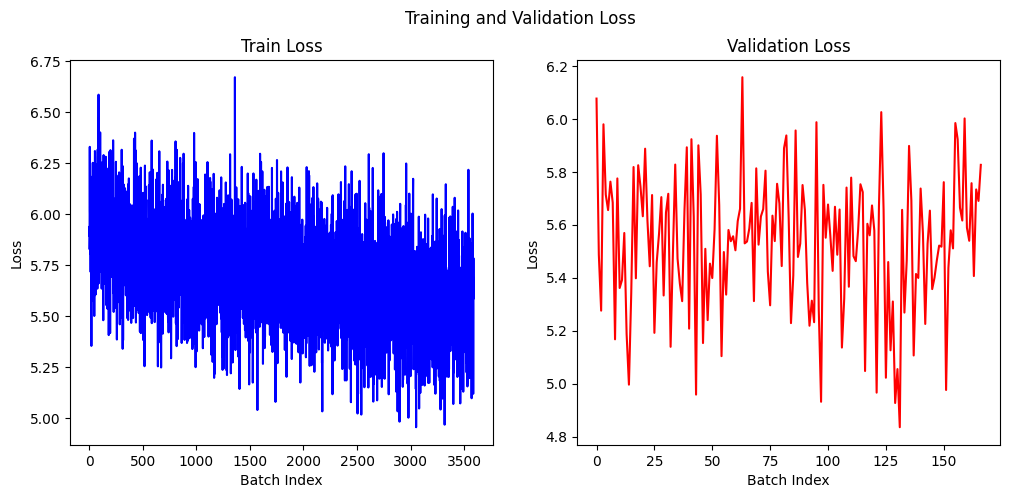

100%|██████████| 167/167 [00:26<00:00,  6.19it/s, loss=5.75]


Epoch: 3, Train Loss: 5.3625, Val ROUGE-L: 0.1215, Val ROUGE-2: 0.0105


<Figure size 640x480 with 0 Axes>

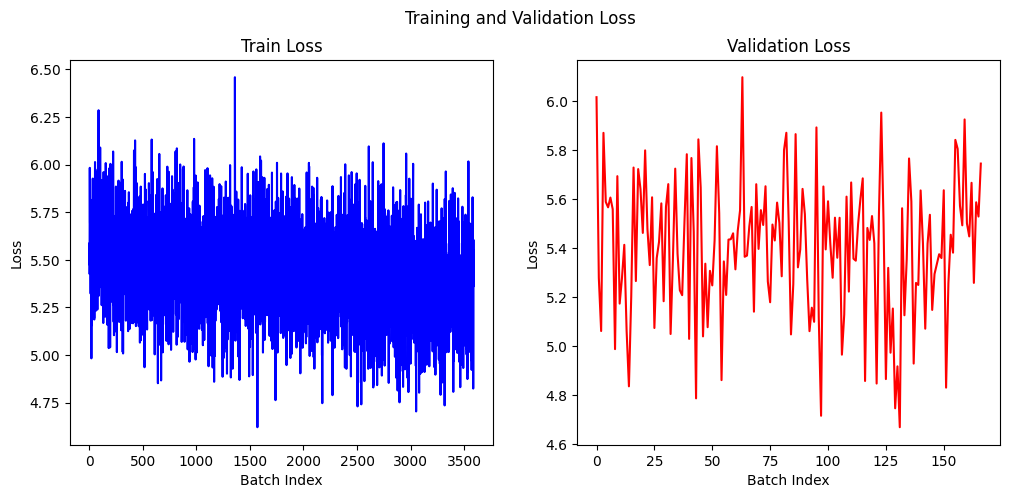

Early stopping at epoch 3...


In [19]:
train(train_dataloader, val_dataloader, model, n_epochs=10)

## VI. Inference Stage: Making Predictions!

In [20]:
torch.save(model.state_dict(), "model.pth")

In [21]:
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loss, rouge_scores = eval(test_dataloader, model, nn.NLLLoss(ignore_index=PAD_IDX))
print(f"Test ROUGE-L: {rouge_scores['Rouge-L-F']:.4f}, Test ROUGE-2: {rouge_scores['Rouge-2-F']:.4f}")

100%|██████████| 1437/1437 [03:41<00:00,  6.49it/s, loss=4.96]

Test ROUGE-L: 0.1243, Test ROUGE-2: 0.0105


# Part 2: Applying the Model to New Data (20 Marks)

In [22]:
def collate_fn(batch: list):
    """ This function pads inputs with pad_idx to have batches of equal length """
    src_batch, tgt_batch = [], []
    for v in batch:
        src_sample = v["full_text"]
        tgt_sample = v["summary"]
        src_batch.append(transform_input_token(src_sample))
        tgt_batch.append(transform_input_token(tgt_sample))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [23]:
wiki_ds = load_dataset("jordiclive/wikipedia-summary-dataset")
wiki_ds = wiki_ds["train"].select(list(range(10000)))

README.md:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


df_withDescription.parquet:   0%|          | 0.00/8.65G [00:00<?, ?B/s]

df_withoutDescription.parquet:   0%|          | 0.00/6.77G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [24]:
wiki_dataloader = DataLoader(wiki_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
loss, rouge_scores = eval(wiki_dataloader, model, nn.NLLLoss(ignore_index=PAD_IDX))
print(f"Wiki ROUGE-L: {rouge_scores['Rouge-L-F']:.4f}, Wiki ROUGE-2: {rouge_scores['Rouge-2-F']:.4f}")

100%|██████████| 1250/1250 [25:35<00:00,  1.23s/it, loss=6.89]

Wiki ROUGE-L: 0.1272, Wiki ROUGE-2: 0.0233
